# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [52]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage


raw_each = [0] * 10
for i in range(0,10):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[2],raw_each[4],raw_each[5],raw_each[6]])
# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[4],raw_each[3]])
# raw_edf = mne.concatenate_raws([raw_each[2],raw_each[5],raw_each[6],raw_each[7]])
raw_edf = mne.concatenate_raws([raw_each[9]])

# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

# eegbci.standardize(raw_edf)  # set channel names
# montage = make_standard_montage("standard_1005")
# raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...


Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand5_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand6_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand7_n

In [53]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, Dropout,LSTM,Reshape
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [54]:
# eeg1 = raw_edf.copy().set_eeg_reference(ref_channels="average")
eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','Oz','PO8'])
# eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4",'PO7','Oz','PO8'])
component_num = 8

events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 2.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=2.0)
# combine_epochs = combine_epochs.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

nonim_epochs2 = mne.Epochs(eeg1, events, 
        tmin= -2.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 0.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-2.5, -2.0)
    )
nonim_epochs2 = nonim_epochs2.copy().crop(tmin=-2.0, tmax=0.0)
# nonim_epochs2 = nonim_epochs2.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and 751 original time points ...


2 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and 751 original time points ...
1 bad epochs dropped


In [55]:
combine_epochs

Number of events,606
Events,OVTK_GDF_Cross_On_Screen: 3OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 2.000 s
Baseline,-0.500 – 0.000 s


In [56]:
nonim_epochs2

Number of events,607
Events,OVTK_GDF_Cross_On_Screen: 3OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 1
Time range,-2.000 – 0.000 s
Baseline,-2.500 – -2.000 s


In [57]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Left': 5,
 'OVTK_GDF_Right': 6,
 'OVTK_GDF_Start_Of_Trial': 7,
 'OVTK_GDF_Tongue': 8,
 'OVTK_GDF_Up': 9,
 'OVTK_StimulationId_BaselineStart': 10,
 'OVTK_StimulationId_BaselineStop': 11,
 'OVTK_StimulationId_Beep': 12,
 'OVTK_StimulationId_ExperimentStart': 13,
 'OVTK_StimulationId_Train': 14}

# CSP -> CWT -> CNN

In [58]:
class_left = combine_epochs.event_id['OVTK_GDF_Left']
class_right = combine_epochs.event_id['OVTK_GDF_Right']
class_non = combine_epochs.event_id['OVTK_GDF_Tongue']
class_start_trial = combine_epochs.event_id['OVTK_GDF_Start_Of_Trial']
class_up = combine_epochs.event_id['OVTK_GDF_Up']

select_classes = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Tongue']

#######################################################
labels = select_classes.events[:,2]
for i in range(0,len(labels)):
    if labels[i] == class_left:
        labels[i] = 0
    elif labels[i] == class_right:
        labels[i] = 1
    elif labels[i] == class_non or labels[i] == class_start_trial:
        labels[i] = 2
    elif labels[i] == class_up:
        labels[i] = 3
        
train_data1 = select_classes.get_data()
train_data2 = nonim_epochs2['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
# train_data = np.concatenate((train_data1, train_data2), axis=0)
train_data = train_data1

# labels = np.concatenate((labels,np.full((train_data2.shape[0],), 2)), axis = 0)

In [59]:
train_data.shape

(90, 8, 501)

In [60]:
labels

array([2, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 1, 1, 0, 2, 2, 1,
       2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0,
       2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 1, 0,
       1, 0, 2, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 2,
       1, 1])

try csp+lda trined model

In [61]:
csp2 = CSP(n_components=component_num, reg=None, log=None)
csp2.fit(train_data, labels)
with open('trained_csp2_model.pkl', 'wb') as file:
    pickle.dump(csp2, file)

with open('trained_csp2_model.pkl', 'rb') as file:
    trained_csp2 = pickle.load(file)
new_data2 = trained_csp2.transform(train_data)

lda2 = LinearDiscriminantAnalysis()
lda2.fit(new_data2, labels)
with open('trained_lda_model.pkl', 'wb') as file:
    pickle.dump(lda2, file)

with open('trained_lda_model.pkl', 'rb') as file:
    trained_lda = pickle.load(file)

    
score = cross_val_score(trained_lda,new_data2, labels, cv= 10)
lda_predicted = cross_val_predict(trained_lda, new_data2, labels, cv=10)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", score, np.mean(score))
print(conf_matrix)

score = trained_lda.score(new_data2, labels)
lda_predicted = trained_lda.predict(new_data2)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", score)
print(conf_matrix)


Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 8 dim * 7.3e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 8 dim * 7.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
LDA only classification scores [1.         0.88888889 0.88888889 0.88888889 0.88888889 0.77777778
 0.88888889 0.66666667 0.77777778 1.        ] 0.8666666

Try FBCSP

In [62]:
# low_fre = [6, 10, 14, 18, 22, 26]
# high_fre = [12, 16, 20, 24, 28, 32]

# shape = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data().shape

# train_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))

# # FB_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))
# FB_data = np.ndarray(shape= (6,shape[0],shape[1]))


# for i in range(0,6):
#     combine_epochs = combine_epochs.filter(l_freq=low_fre[i], h_freq=high_fre[i], method = 'iir', iir_params= {"order": 5, "ftype":'butter'}, verbose = False)
#     train_data[i] = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
    
#     # csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
#     csp = CSP(n_components=component_num, reg=None, log=None)
#     csp.fit(train_data[i], labels)

#     with open('trained_FBCSP_model'+str(i)+'.pkl', 'wb') as file:
#         pickle.dump(csp, file)

# for j in range(0,6):
#     with open('trained_FBCSP_model'+str(j)+'.pkl', 'rb') as file:
#         trained_csp = pickle.load(file)

#     FB_data[j] = trained_csp.transform(train_data[j])

# FB_data = np.concatenate(FB_data, axis = 1)

In [63]:
# lda3 = LinearDiscriminantAnalysis()
# lda3.fit(FB_data, labels)
# with open('trained_lda3_model.pkl', 'wb') as file:
#     pickle.dump(lda3, file)

# with open('trained_lda3_model.pkl', 'rb') as file:
#     trained_lda3 = pickle.load(file)


# score = cross_val_score(trained_lda3, FB_data, labels, cv= 15)
# lda_predicted = cross_val_predict(trained_lda3, FB_data, labels, cv= 15)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score, np.mean(score))
# print(conf_matrix)

# score = trained_lda3.score(FB_data, labels)
# lda_predicted = trained_lda3.predict(FB_data)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score)
# print(conf_matrix)

train csp

In [64]:
# csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
# csp.fit(train_data, labels)

# with open('trained_csp_newsess_NRL_model.pkl', 'wb') as file:
#     pickle.dump(csp, file)

load csp

In [65]:
with open('trained_csp_newsess_NRL_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)
print(new_data.shape)

(90, 8, 501)


STFT

In [66]:
# from ssqueezepy import ssq_cwt, ssq_stft

# n_fft = 256  # Number of DFT points
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming' 
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size,component_num, 129, 72))


# # _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
# for i in range(0,train_size):
#     _,coeff, *_ = ssq_stft(new_data[i,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
#     train_data_stft[i, :, :, :] = coeff

# print(np.shape(train_data_stft))

# # Stack array and convert to image
# train_stft_stack = np.ndarray(shape=(train_size, train_data_stft.shape[2],train_data_stft.shape[3]*component_num))

# for jj in range(0,train_data_stft.shape[0]):
#     train_stft_stack[jj] = np.concatenate(train_data_stft[jj], axis = 1)
    # train_stft_stack[jj] = np.vstack((train_data_stft[jj,0,:,:], train_data_stft[jj,1,:,:], train_data_stft[jj,2,:,:], train_data_stft[jj,3,:,:], train_data_stft[jj,4,:,:], train_data_stft[jj,5,:,:], train_data_stft[jj,6,:,:]))

# print(np.shape(train_stft_stack))

# train_cwt_stack= train_stft_stack

CWT

In [67]:
FB = 1
# new_data = train_data
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num*FB))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(train_cwt))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num*FB))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num*FB):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]] 
        train_data_cwt[ii, :, :, jj] = abs(coeff_)
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num*FB, new_data.shape[2]))

# train_cwt_stack = np.ndarray(shape=(train_size , new_data.shape[2], len(scales)*component_num*FB))

for jj in range(0,train_data_cwt.shape[0]):
    # train_cwt_stack[jj] = np.concatenate(train_data_cwt[jj], axis = 1)
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6],train_data_cwt[jj,:,:,7]))
    # train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2]))
print(np.shape(train_cwt_stack))

(90, 501, 8)
0


40
80
(90, 30, 501, 8)
(90, 240, 501)


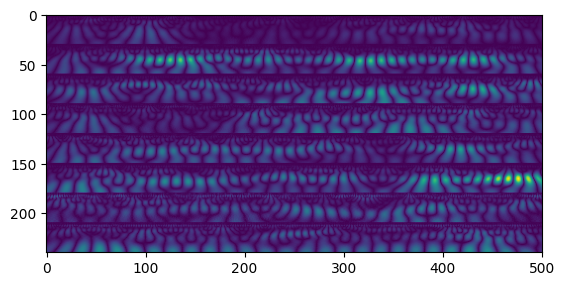

In [68]:
plt.imshow(train_cwt_stack[0])

In [69]:
for ii in range(0,train_cwt_stack.shape[0]):
    print(train_cwt_stack[ii].max(), ii)

12.27946164143719 0
18.659613515039624 1
12.883713539001256 2
14.00723266784113 3
10.561233207888304 4
15.249835551974849 5
12.667048618188232 6
15.42920196991694 7
12.922418283251636 8
13.533509769766068 9
18.233060194246026 10
13.377569898553528 11
17.580027477621897 12
13.754874203690546 13
15.317133259950555 14
10.315992570184218 15
16.654095768796584 16
11.906100386777974 17
14.08584905356816 18
13.79146617903471 19
15.799048693776712 20
13.590724888265939 21
9.307232660173716 22
12.20159364955061 23
18.128490428592464 24
15.77569996820023 25
11.450352673096326 26
13.928959914780702 27
12.982184303769166 28
11.577714367104871 29
14.242492865455262 30
11.564564644041425 31
14.82465980839083 32
12.771603908962943 33
15.014525359080409 34
15.149151412226095 35
12.95443201732822 36
17.425627489817106 37
17.4075167216762 38
12.600516200564915 39
17.226308968835394 40
11.56744806544836 41
12.502666257381462 42
16.9651521087537 43
17.191733194727053 44
12.357784247253964 45
16.6990964694

In [70]:
train_cwt_stack = np.delete(train_cwt_stack, 68, axis = 0)
labels = np.delete(labels, 68)

Try scaler

In [71]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# reshaped_data = train_cwt_stack.reshape((train_cwt_stack.shape[0], -1))
# scaled_data = scaler.fit_transform(reshaped_data)
# scaled_data_3d = scaled_data.reshape(train_cwt_stack.shape)
# print(scaled_data_3d.shape)

In [72]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# scaled_data =  np.ndarray(shape=(int(train_cwt_stack.shape[0]),int(train_cwt_stack.shape[1]),int(train_cwt_stack.shape[2])))
# for ii in range(0,train_cwt_stack.shape[0]):
#     scaled_data[ii] = scaler.fit_transform(train_cwt_stack[ii])

In [73]:
# for ii in range(0,scaled_data.shape[0]):
#     print(scaled_data[ii].mean(), ii)

train_test split

In [74]:
# train_cwt_stack = scaled_data
x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

num_classes = len(np.unique(labels))
lowest = np.min(y_train)
batch_size = 1
epochs = 15
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train-lowest, num_classes)
y_test = keras.utils.to_categorical(y_test-lowest, num_classes)

(62, 240, 501) (27, 240, 501) (62,) (27,)


# Purposed CNN Model

In [75]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1 with 32 filters of kernel size 3x3
model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2],1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2 with 64 filters of kernel size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3 with 128 filters of kernel size 3x3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output from the previous layer
# model.add(Flatten())

# model.add(Dense(1024, activation='softmax'))

model.add(Reshape(target_shape=(28, 60*128)))
model.add(LSTM(100, activation='relu'))

# Flatten the output from the previous layer
model.add(Flatten())

# Output Layer with the desired number of output nodes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
              metrics=['accuracy'])

model.summary()
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
checkpoint = ModelCheckpoint("CNN_model_newsess_NRL_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history, checkpoint])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 238, 499, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 238, 499, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 119, 249, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 117, 247, 64)      18496     
                                                                 
 batch_normalization_16 (Ba  (None, 117, 247, 64)      256       
 tchNormalization)                                               
                                                      

C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - ETA: 0s - loss: 2.2893 - accuracy: 0.5161
Epoch 2: val_accuracy improved from 0.29630 to 0.33333, saving model to CNN_model_newsess_NRL_weights.h5
62/62 [==============================] - 21s 341ms/step - loss: 2.2893 - accuracy: 0.5161 - val_loss: 1.2178 - val_accuracy: 0.3333
Epoch 3/15
62/62 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.8226
Epoch 3: val_accuracy did not improve from 0.33333
62/62 [==============================] - 21s 336ms/step - loss: 0.5827 - accuracy: 0.8226 - val_loss: 1.3164 - val_accuracy: 0.2963
Epoch 4/15
62/62 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9516
Epoch 4: val_accuracy did not improve from 0.33333
62/62 [==============================] - 21s 336ms/step - loss: 0.2156 - accuracy: 0.9516 - val_loss: 1.3076 - val_accuracy: 0.2963
Epoch 5/15
62/62 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9839
Epoch 5: val_accuracy did not im

3/3 [==============================] - 2s 528ms/step


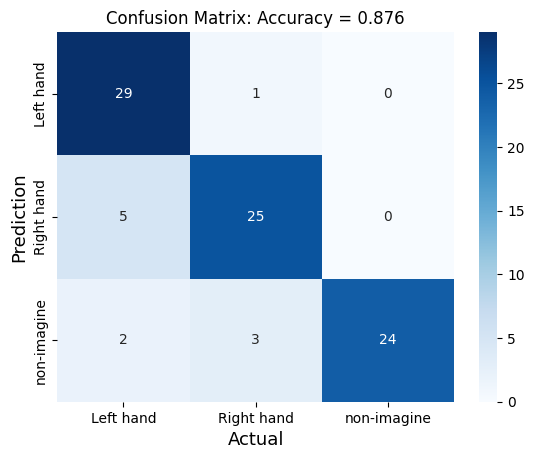

In [76]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_newsess_NRL_weights.h5")

y_test = keras.utils.to_categorical(labels-lowest, num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

# class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

# class_names = ['Right hand','Non-imagine']

# class_names = ['Imagine','Non-imagine']

class_names = ['Left hand', 'Right hand', 'non-imagine']

# class_names = ['Left hand', 'Right hand', 'Up']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()